In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram

import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline

import numpy as np
import networkx as nx
import random

4


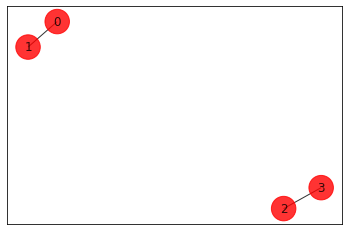

In [2]:
n = 4 # number of node
edge_direct = random.randint(1, n)
weight = 1.0
print(edge_direct)
elist=[(2,3,1.0), (0, 1, 1.0)]
G=nx.Graph()
G.add_nodes_from(np.arange(0, n,1))
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)

In [3]:
w = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i,j,default=0)
        print(temp)
        if temp != 0:
            w[i,j] = temp["weight"] 
print(w)

0
{'weight': 1.0}
0
0
{'weight': 1.0}
0
0
0
0
0
0
{'weight': 1.0}
0
0
{'weight': 1.0}
0
[[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]


In [4]:
edges = list(G.edges)
print(edges)

while edges:
    i, j = edges.pop()
    print(i, j)

[(0, 1), (2, 3)]
2 3
0 1


In [5]:

## difine circuit

num_x = n # num of node
num_a = 1
num_b = 2
num_c = 1

x = QuantumRegister(num_x, "x")
a = QuantumRegister(num_a, "a")
b = QuantumRegister(num_b, "b")
c = QuantumRegister(num_c, "c")

cr = ClassicalRegister(4, "cr")
qc = QuantumCircuit(x, a ,b, c,  cr)

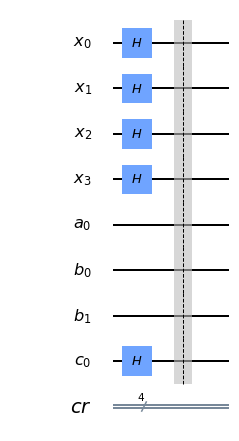

In [6]:
#initialize graph weight
#If Threshold >=2 : SUCCESS!!

qc = QuantumCircuit(x, a ,b, c,  cr)

qc.h(x[0])
qc.h(x[1])
qc.h(x[2])
qc.h(x[3])

qc.h(c[0])

qc.barrier()
qc.draw(output = "mpl")

[(0, 1), (2, 3)]
4
0 1
success!
2 3
success!
2 3
success!
0 1
success!


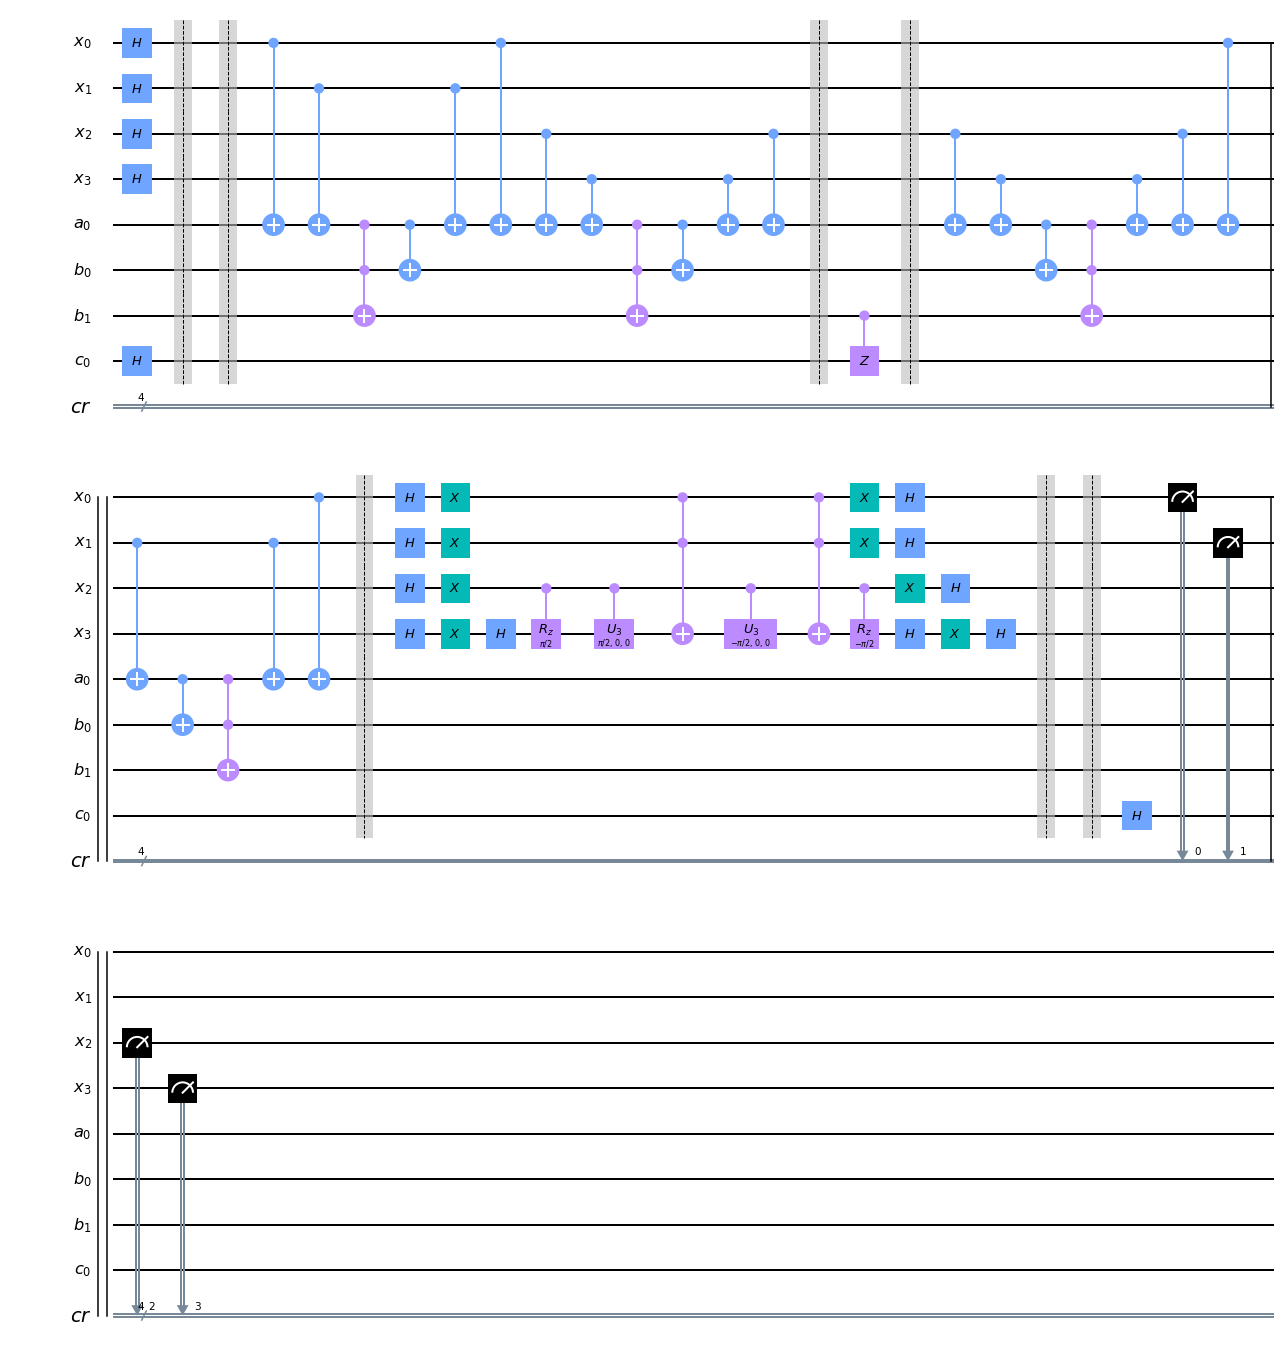

In [7]:
edges = list(G.edges)
print(edges)

# Oracle part of grover
def cut(qc, x, a, b, i, j):
    
    qc.cx(x[i], a)
    qc.cx(x[j], a)

    qc.ccx(a[0], b[0], b[1])
    qc.cx(a[0], b[0])

    qc.cx(x[j], a)
    qc.cx(x[i], a)
    
# inverse part of grover
def icut(qc, x, a, b, i, j):
    
    qc.cx(x[i], a)
    qc.cx(x[j], a)

    qc.cx(a[0], b[0])
    qc.ccx(a[0], b[0], b[1])
    
    qc.cx(x[j], a)
    qc.cx(x[i], a)
    
    
def cnx(qc,*qubits): # C^n-NOT gate
    if len(qubits) > 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu3(np.pi/2, 0, 0, qubits[-2],qubits[-1])
        
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #B matrix (cry again, but opposite angle)
        qc.cu3(-np.pi/2, 0, 0, qubits[-2], qubits[-1])
        
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
    elif len(qubits)==3:
        qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)

print(num_x)

# Diffusion matrix
def diff(qc, N): 
    for k in range(N):
        qc.h(x[k])
        qc.x(x[k])

    qc.h(x[3])
    cnx(qc, x[0], x[1], x[2], x[3])
    qc.h(x[3])

    for k in range(N):
        qc.x(x[k])
        qc.h(x[k])

for l in np.arange(1):
    qc.barrier()
    for e in edges:
        i, j = e
        print(i, j)
        cut(qc, x, a, b, int(i), int(j)) # when we should apply int ? Is this right timing?
        print("success!")
    
    qc.barrier()
    qc.cz(b[1], c[0])
    qc.barrier()
    
    for e in edges[::-1]:
        i, j = e
        print(i, j)
        icut(qc, x, a, b, int(i), int(j)) # when we should apply int ? Is this right timing?
        print("success!")
    
    qc.barrier()
    diff(qc, num_x)
    qc.barrier()


qc.barrier()

qc.h(c[0])
## measurement
for l in range(num_x):
    qc.measure(x[l], cr[l])

qc.draw(output = "mpl")

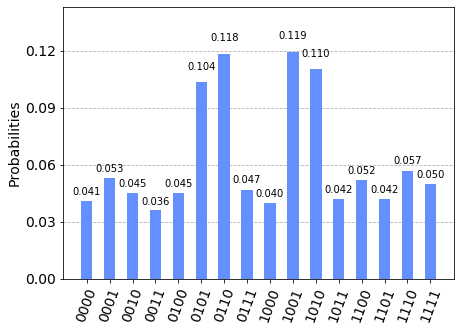

In [10]:
backend = Aer.get_backend('qasm_simulator')

job_sim = execute(qc, backend=backend)
result = job_sim.result()
count = result.get_counts(qc)
plot_histogram(count)